# Quickstart: ECMWF IFS ENS forecast, 15 day, 0.25 degree - dynamical.org Icechunk Zarr
A brief introduction to the ECMWF IFS Ensemble forecast dataset transformed into an analysis-ready, cloud-optimized format by dynamical.org.

Dataset documentation: https://dynamical.org/catalog/ecmwf-ifs-ens-forecast-15-day-0-25-degree/

Dataset licenced [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/) and [ECMWF Terms of Use](https://apps.ecmwf.int/datasets/licences/general/)


In [ ]:
# If running locally, follow README.md for simple dependency installation.
# If using Google Colab, run this cell and then restart the notebook.
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.8" icechunk

In [1]:
import icechunk
import xarray as xr

storage = icechunk.s3_storage(bucket="dynamical-ecmwf-ifs-ens", prefix="ecmwf-ifs-ens-forecast-15-day-0-25-degree/v0.1.0.icechunk/", region="us-west-2", anonymous=True)
repo = icechunk.Repository.open(storage)
session = repo.readonly_session("main")
ds = xr.open_zarr(session.store, chunks=None)
ds

<xarray.Dataset> Size: 155TB
Dimensions:                                     (init_time: 661, lead_time: 85,
                                                 ensemble_member: 51,
                                                 latitude: 721, longitude: 1440)
Coordinates:
  * ensemble_member                             (ensemble_member) int16 102B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 5kB ...
    ingested_forecast_length                    (init_time) timedelta64[ns] 5kB ...
  * init_time                                   (init_time) datetime64[ns] 5kB ...
  * latitude                                    (latitude) float64 6kB 90.0 ....
  * lead_time                                   (lead_time) timedelta64[ns] 680B ...
  * longitude                                   (longitude) float64 12kB -180...
    spatial_ref                                 int64 8B ...
    valid_time                                  (init_time, lead_time) datetime64[ns] 449kB ...
Data variables: (12/13)
    categorical_precipitation_type_surface      (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    dew_point_temperature_2m                    (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    downward_long_wave_radiation_flux_surface   (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    downward_short_wave_radiation_flux_surface  (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    geopotential_height_500hpa                  (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    precipitation_surface                       (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    ...                                          ...
    pressure_surface                            (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    temperature_2m                              (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    wind_u_100m                                 (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    wind_u_10m                                  (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    wind_v_100m                                 (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
    wind_v_10m                                  (init_time, lead_time, ensemble_member, latitude, longitude) float32 12TB ...
Attributes:
    dataset_id:           ecmwf-ifs-ens-forecast-15-day-0-25-degree
    dataset_version:      0.1.0
    name:                 ECMWF IFS ENS Forecast, 15 day, 0.25 degree
    description:          Ensemble weather forecasts from the ECMWF Integrate...
    attribution:          ECMWF IFS ENS Forecast data processed by dynamical....
    spatial_domain:       Global
    spatial_resolution:   0.25 degrees (~20km)
    time_domain:          Forecasts initialized 2024-04-01 00:00:00 UTC to Pr...
    time_resolution:      Forecasts initialized every 24 hours
    forecast_domain:      Forecast lead time 0-360 hours (0-15 days) ahead
    forecast_resolution:  Forecast step 0-144 hours: 3 hourly, 144-360 hours:...

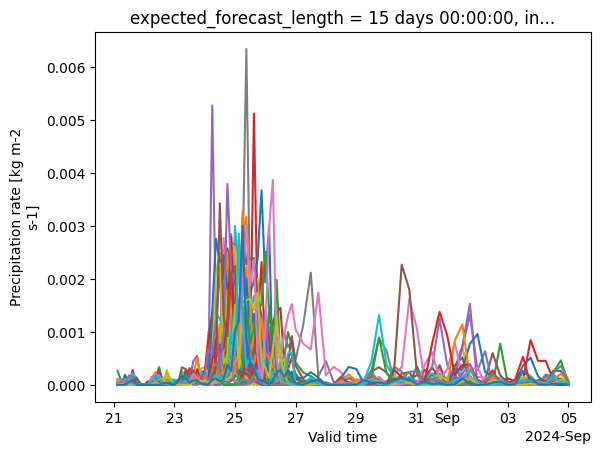

In [2]:
# Plot the ensemble traces for one forecast and variable at a point on the earth
plot_ds = ds.sel(init_time="2024-08-21T00", latitude=19.75, longitude=-155.0, method="nearest")  # Hilo, Island of Hawai'i
_ = plot_ds["precipitation_surface"].plot(x="valid_time", hue="ensemble_member", add_legend=False)

Text(0.5, 1.0, "Control + Perturbed members for the 2024-08-21 precipitation forecast for Hilo, Hawai'i\n(4 days before Hurricane Hone reached the Big Island)")

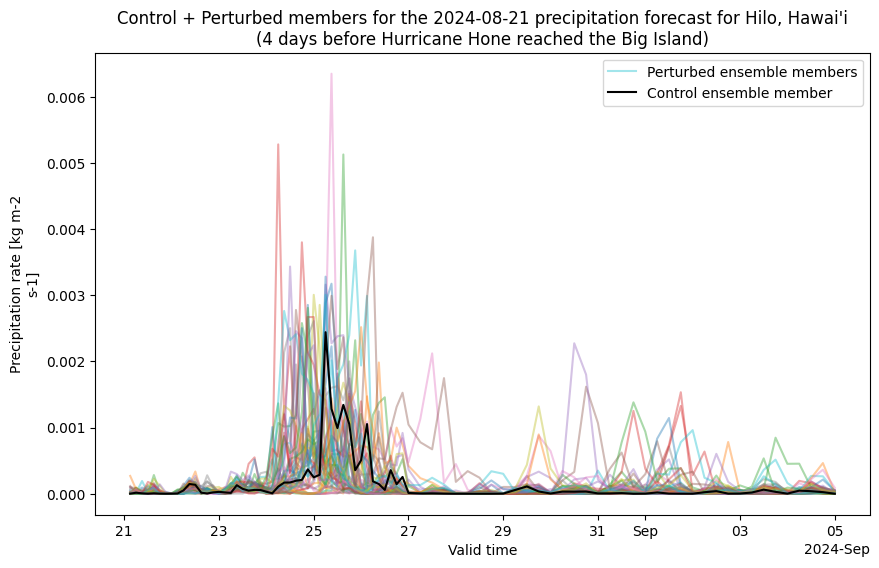

In [3]:
# Getting a little fancier with our plotting: a nicer visualization of the ensemble for that same forecast

import matplotlib.pyplot as plt

plot_ds = ds.sel(init_time="2024-08-21T00", latitude=19.75, longitude=-155.0, method="nearest")
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

( # Plot all the perturbed members (ensemble_members 1 through 51) with low opacity
    plot_ds["precipitation_surface"]
    .sel(ensemble_member=slice(1, 51))
    .plot(x="valid_time", hue="ensemble_member", ax=ax, alpha=0.4, label="Perturbed ensemble members")
)
( # Plot the control (ensemble_member 0) on top in black
    plot_ds["precipitation_surface"]
    .sel(ensemble_member=0)
    .plot(x="valid_time", ax=ax, color="black", label="Control ensemble member")
)

# Clean up legend, use one legend entry for all 50 perturbed members
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])  
ax.set_title("Control + Perturbed members for the 2024-08-21 precipitation forecast for Hilo, Hawai'i\n(4 days before Hurricane Hone reached the Big Island)")

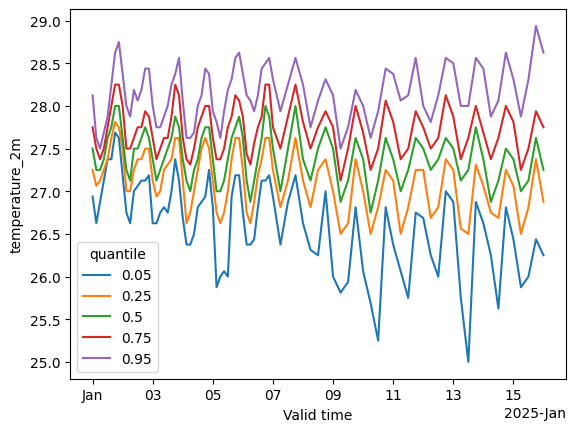

In [4]:
# Plot a summary of the ensemble distribution using quantiles
plot_ds = ds.sel(init_time="2025-01-01T00", latitude=0, longitude=0)
(
    plot_ds["temperature_2m"]
    .quantile([0.05, 0.25, 0.5, 0.75, 0.95], dim="ensemble_member")
    .plot(x="valid_time", hue="quantile")
)

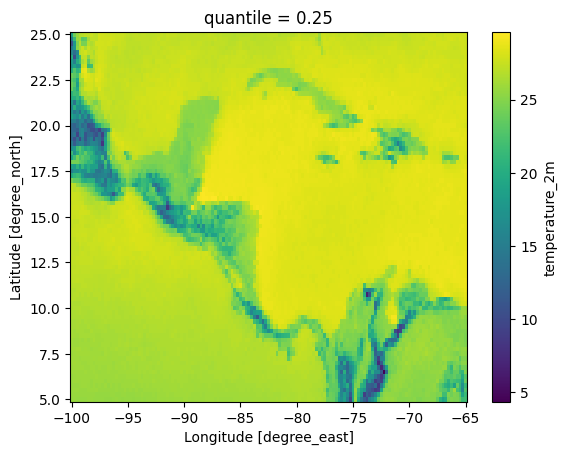

In [5]:
# Calculate a quantile across ensemble members and display the result as a map
(
    ds["temperature_2m"]
    .sel(init_time="2024-10-01T00")
    .sel(lead_time="7d")
    .sel(latitude=slice(25, 5), longitude=slice(-100, -65)) # Central America and the Caribbean
    .quantile(0.25, dim="ensemble_member") # 25% chance it gets colder than this
    .plot()
);

Text(0.5, 1.0, 'Ensemble standard deviation 2 meter temperature [degree_Celsius]')

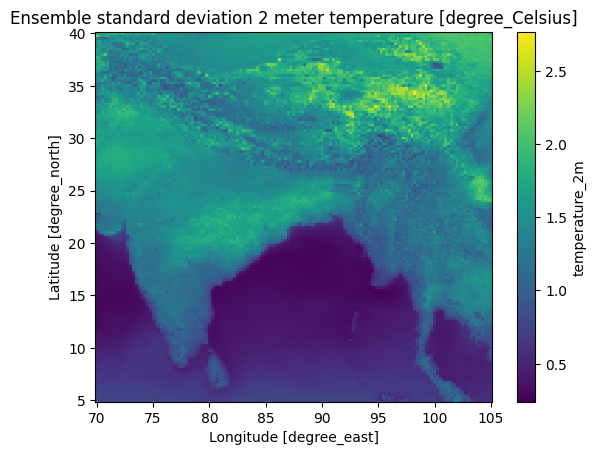

In [6]:
# Highlight areas of uncertainty in a 15 day temperature forecast

plot_ds = ds.sel(init_time="2024-04-03T00", latitude=slice(40, 5), longitude=slice(70, 105))

# Standard deviation across ensemble members to highlight regions of forecast uncertainty
plot_ds["temperature_2m"].std(dim="ensemble_member").mean(dim="lead_time").plot()
plt.title(f"Ensemble standard deviation 2 meter temperature [{ds['temperature_2m'].attrs['units']}]")